# [Lab Session 4](deconvolution.ipynb)

In [72]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

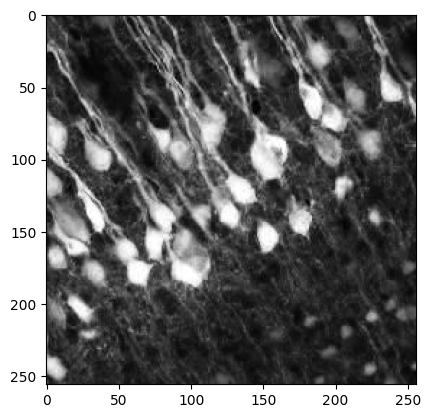

In [73]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

In [74]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2

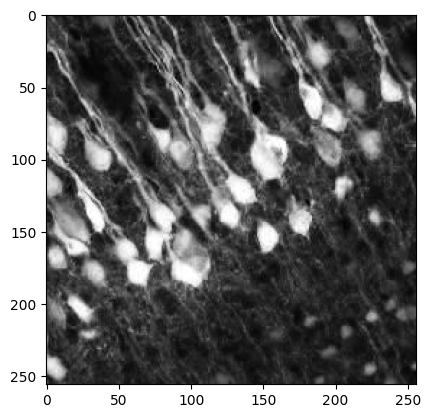

In [75]:
img1 = conv(img, psf, mode='same', boundary='symm') 

plt.imshow(img, 'gray')

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

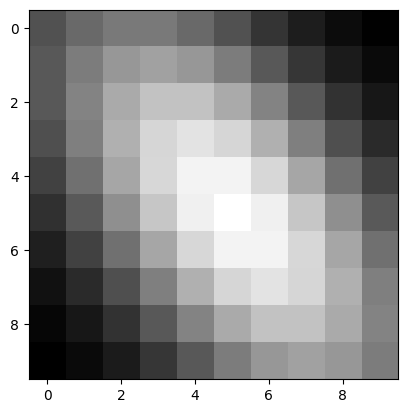

In [76]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

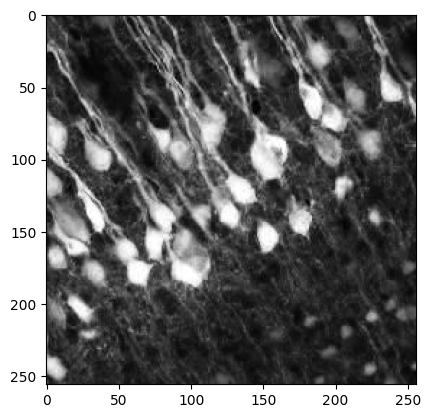

In [77]:
img2 = conv(img, create_psf(psf_size), mode='same', boundary='symm') 

plt.imshow(img, 'gray')

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [85]:
P_star = np.flip(psf)

def richardson_lucy_deconvolution(image, psf, n_iterations):
    img_deconv = np.full(image.shape, 0.5)
    P_star = np.flip(psf)
    h = img_deconv

    for _ in range(n_iterations):
        t1 = conv(img_deconv, psf, mode="same", boundary="symm")
        t1[t1==0]  = 1e-12              # h * P
        ratio = image / t1 
        t3 = image/t1                                                    # g / (h*P)
        t3 = conv(ratio, psf, mode="same", boundary="symm")                 # P* * ratio
        h *= t3                                                # update
    
    img_deconv = img_deconv.clip(0, 1)

    return img_deconv



**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

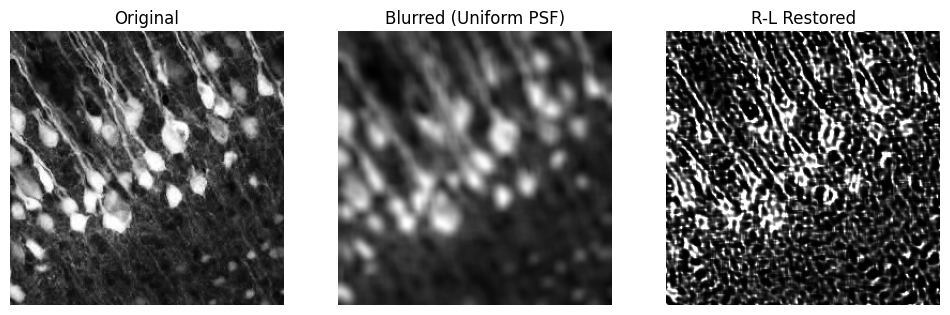

In [99]:
restored = richardson_lucy_deconvolution(img, create_psf(psf_size), n_iterations=100)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray"); plt.title("Original"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img1, cmap="gray"); plt.title("Blurred (Uniform PSF)"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(restored, cmap="gray"); plt.title("R-L Restored"); plt.axis("off")
plt.show()


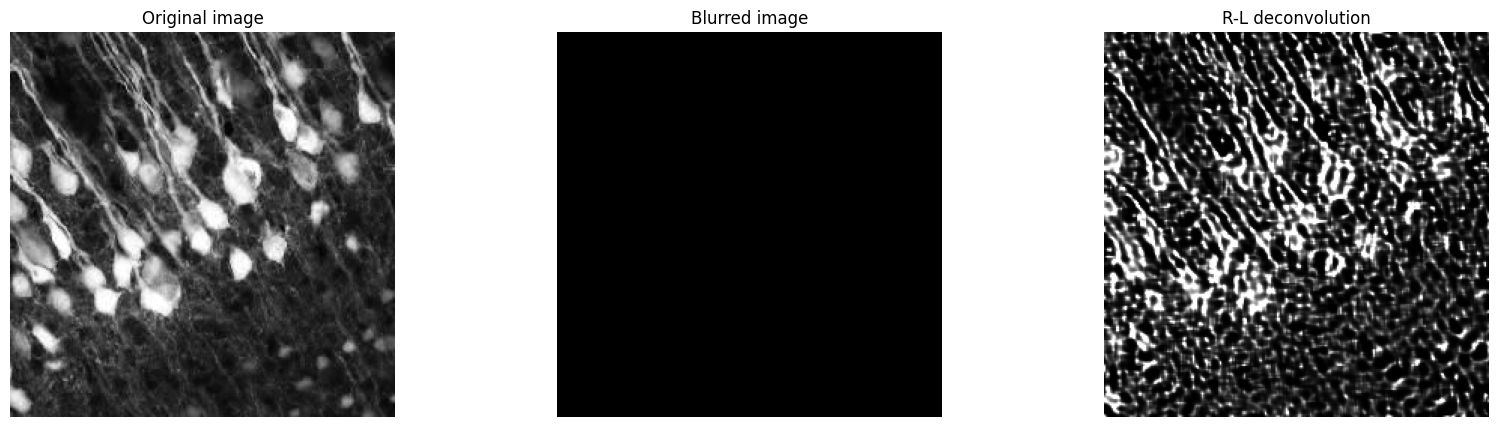

In [100]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(psf, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(restored, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [101]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor
noise = noise + img
noisy_img = np.clip(noise, 0, 1)

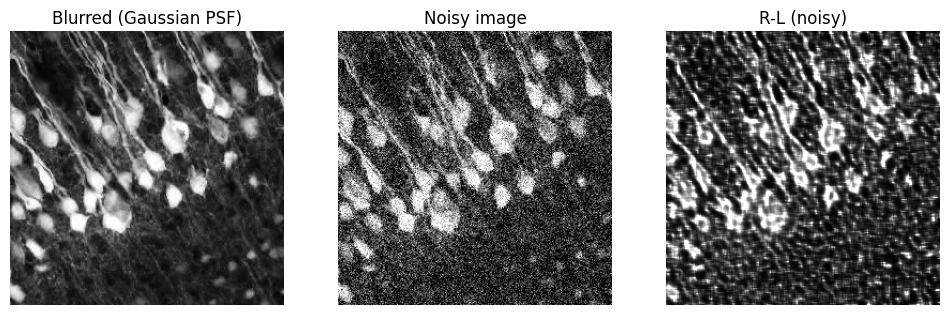

In [102]:
restored_noisy = richardson_lucy_deconvolution(noisy_img, create_psf(psf_size), 20)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray"); plt.title("Blurred (Gaussian PSF)"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(noisy_img, cmap="gray"); plt.title("Noisy image"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(restored_noisy, cmap="gray"); plt.title("R-L (noisy)"); plt.axis("off")
plt.show()


**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

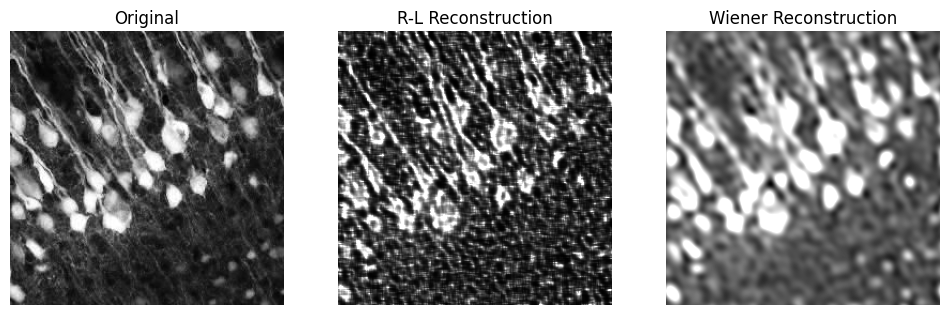

In [103]:
restored_wiener = wiener(noisy_img, create_psf(psf_size), balance=2, clip=True)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray"); plt.title("Original"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(restored_noisy, cmap="gray"); plt.title("R-L Reconstruction"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(restored_wiener, cmap="gray"); plt.title("Wiener Reconstruction"); plt.axis("off")
plt.show()


**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

(-0.5, 255.5, 255.5, -0.5)

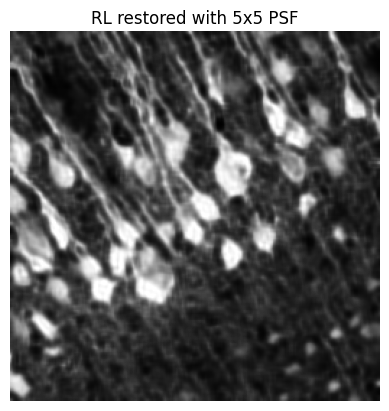

In [107]:
psf_size = 5
psf = np.ones((psf_size, psf_size)) / psf_size ** 2
img_blur_small = conv(img, psf, mode="same", boundary="symm")

restored_small = richardson_lucy_deconvolution(img_blur_small, psf_uniform_small, 20)

plt.imshow(restored_small, cmap="gray")
plt.title("RL restored with 5x5 PSF")
plt.axis("off")


**[Task 8.]()** Use a wrong PSF to restore the image

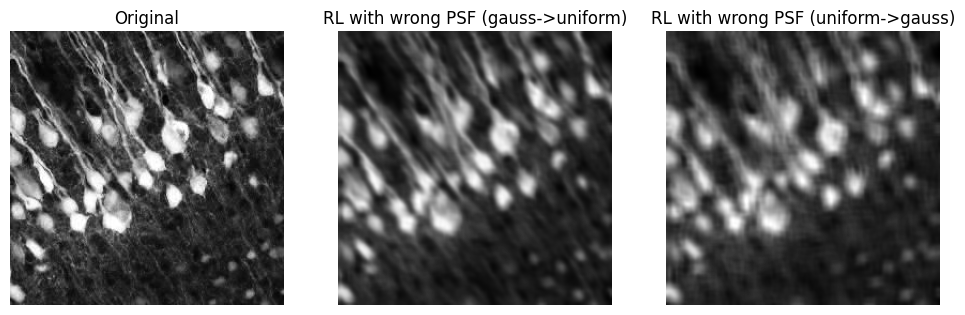

In [110]:
restored_wrong1 = richardson_lucy_deconvolution(img2, psf, 20)

restored_wrong2 = richardson_lucy_deconvolution(img1, create_psf(psf_size), 20)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray"); plt.title("Original"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(restored_wrong1, cmap="gray"); plt.title("RL with wrong PSF (gauss->uniform)"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(restored_wrong2, cmap="gray"); plt.title("RL with wrong PSF (uniform->gauss)"); plt.axis("off")
plt.show()
